In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.simulation import simulate_data
from src.preprocessing import preprocess_dataframe
from src.models import fit_logistic_regression, extract_gender_effect
from src.models import evaluate_decision_tree, plot_decision_tree, plot_feature_importance

### Our Hypothesis:

Null: There is *no gender bias* in income levels after controlling for education and occupation.

Alternative: There *is evidence of gender bias* in income levels after controlling for education and occupation.

(np.float64(-0.5), np.float64(938.5), np.float64(519.5), np.float64(-0.5))

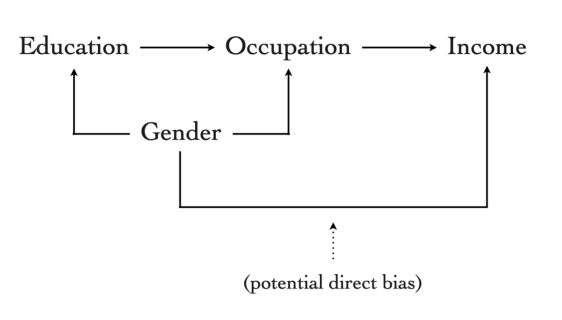

In [2]:
# Showing Graphical Model with key variables
img = mpimg.imread("figures/Graphical_Model.png")
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.axis("off")

### Simulators:

In [3]:
# Simulator A
df_null = simulate_data(n_samples=5000, bias=False, seed=42)

# Simulator B
df_biased = simulate_data(n_samples=5000, bias=True, seed=43)

df_null.head(), df_biased.head()

(   gender education    occupation  income
 0    Male      high  professional       1
 1    Male       low        manual       0
 2  Female      high        manual       0
 3  Female       low        manual       0
 4    Male    medium        manual       0,
   gender education    occupation  income
 0   Male    medium        manual       0
 1   Male      high  professional       1
 2   Male    medium        manual       0
 3   Male       low       service       0
 4   Male       low        manual       0)

## Logistic Regression

In [4]:
# Simulation - Null Hypothesis (no gender bias)
df_null = simulate_data(n_samples=5000, bias=False, seed=0)
X_null, y_null = preprocess_dataframe(df_null)

model_null = fit_logistic_regression(X_null, y_null)
extract_gender_effect(model_null)

{'coef': np.float64(0.0012870549613181181),
 'p_value': np.float64(0.9842280487473706),
 'ci_lower': -0.12631907383293414,
 'ci_upper': 0.12889318375557038,
 'odds_ratio': np.float64(1.0012878835720058)}

In [5]:
# Simulation - Alternative Hypothesis (gender bias)
df_biased = simulate_data(n_samples=5000, bias=True, seed=0)
X_biased, y_biased = preprocess_dataframe(df_biased)

model_biased = fit_logistic_regression(X_biased, y_biased)
extract_gender_effect(model_biased)

{'coef': np.float64(-0.6874004327015435),
 'p_value': np.float64(1.4512439900071942e-23),
 'ci_lower': -0.8220632494314553,
 'ci_upper': -0.5527376159716317,
 'odds_ratio': np.float64(0.5028816460452682)}

Simulation-Based Validation:

In [6]:
n_simulations = 200 # number of repetitions
n_samples = 1000  # sample size
alpha = 0.05 # significance level / threshold

In [7]:
# Estimate Type I error (false positives) on null hypothesis
false_positives = 0

for i in range(n_simulations):
    df = simulate_data(n_samples=n_samples, bias=False, seed=i)

    X, y = preprocess_dataframe(df)
    model = fit_logistic_regression(X, y)
    result = extract_gender_effect(model)

    if result["p_value"] < alpha:
        false_positives += 1

type_1_error = false_positives / n_simulations
print("Type I error rate:", type_1_error)

Type I error rate: 0.05


In [8]:
# Estimate power on alternative hypothesis
true_positives = 0

for i in range(n_simulations):
    df = simulate_data(n_samples=n_samples, bias=True, seed=i)

    X, y = preprocess_dataframe(df)
    model = fit_logistic_regression(X, y)
    result = extract_gender_effect(model)

    if result["p_value"] < alpha:
        true_positives += 1

power = true_positives / n_simulations
print("Power:", power)

Power: 0.99


In [9]:
# Evaluate how Type I error and Power change with sample size
sample_sizes = [200, 500, 1000, 5000]
n_simulations = 200
alpha = 0.05

results = []

for n_samples in sample_sizes:

    # Type I Error on zero hypothesis
    false_positives = 0

    for i in range(n_simulations):
        df = simulate_data(n_samples=n_samples, bias=False, seed=i)

        X, y = preprocess_dataframe(df)
        model = fit_logistic_regression(X, y)
        result = extract_gender_effect(model)

        if result["p_value"] < alpha:
            false_positives += 1

    type_1_error = false_positives / n_simulations

    # Power on alternative hypothesis
    true_positives = 0

    for i in range(n_simulations):
        df = simulate_data(n_samples=n_samples, bias=True, seed=i)

        X, y = preprocess_dataframe(df)
        model = fit_logistic_regression(X, y)
        result = extract_gender_effect(model)

        if result["p_value"] < alpha:
            true_positives += 1

    power = true_positives / n_simulations

    results.append({"Sample size": n_samples, "Type I error": type_1_error, "Power": power})

In [10]:
results_df = pd.DataFrame(results)
results_df

,Sample size,Type I error,Power
0,200,0.045,0.525
1,500,0.055,0.920
2,1000,0.050,0.990
3,5000,0.060,1.000


### Logistic Regression: Real Data (Adult Income Dataset)

In [11]:
adult_df = pd.read_csv("data/adult.csv")
adult_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [12]:
adult_df["occupation"].value_counts()

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

In [13]:
# Preprocessing
X_adult, y_adult = preprocess_dataframe(adult_df)
X_adult.head(), y_adult.head()

(   gender  education_mapped_low  education_mapped_medium  \
 0       0                   1.0                      0.0   
 1       0                   1.0                      0.0   
 2       0                   0.0                      1.0   
 3       0                   0.0                      1.0   
 5       0                   1.0                      0.0   
 
    occupation_mapped_professional  occupation_mapped_service  
 0                             0.0                        0.0  
 1                             0.0                        0.0  
 2                             0.0                        1.0  
 3                             0.0                        0.0  
 5                             0.0                        1.0  ,
 0    0
 1    0
 2    1
 3    1
 5    0
 Name: income, dtype: int64)

In [14]:
# Preprocessing - check
X_adult.isna().sum()

gender                            0
education_mapped_low              0
education_mapped_medium           0
occupation_mapped_professional    0
occupation_mapped_service         0
dtype: int64

In [15]:
# Model + Result
adult_model = fit_logistic_regression(X_adult, y_adult)
adult_gender_effect = extract_gender_effect(adult_model)

adult_gender_effect

{'coef': np.float64(-1.5070591375530036),
 'p_value': np.float64(0.0),
 'ci_lower': -1.5677367321319717,
 'ci_upper': -1.4463815429740354,
 'odds_ratio': np.float64(0.2215606000438354)}

## Additional Experiments

### Decision Tree: Simulation H0 (no gender bias)

In [16]:
X_null, y_null = preprocess_dataframe(df_null)

dt_null = evaluate_decision_tree(X_null, y_null)
print("Decision Tree Accuracy (H0 - no bias):", dt_null["accuracy"])

Decision Tree Accuracy (H0 - no bias): 0.6893333333333334


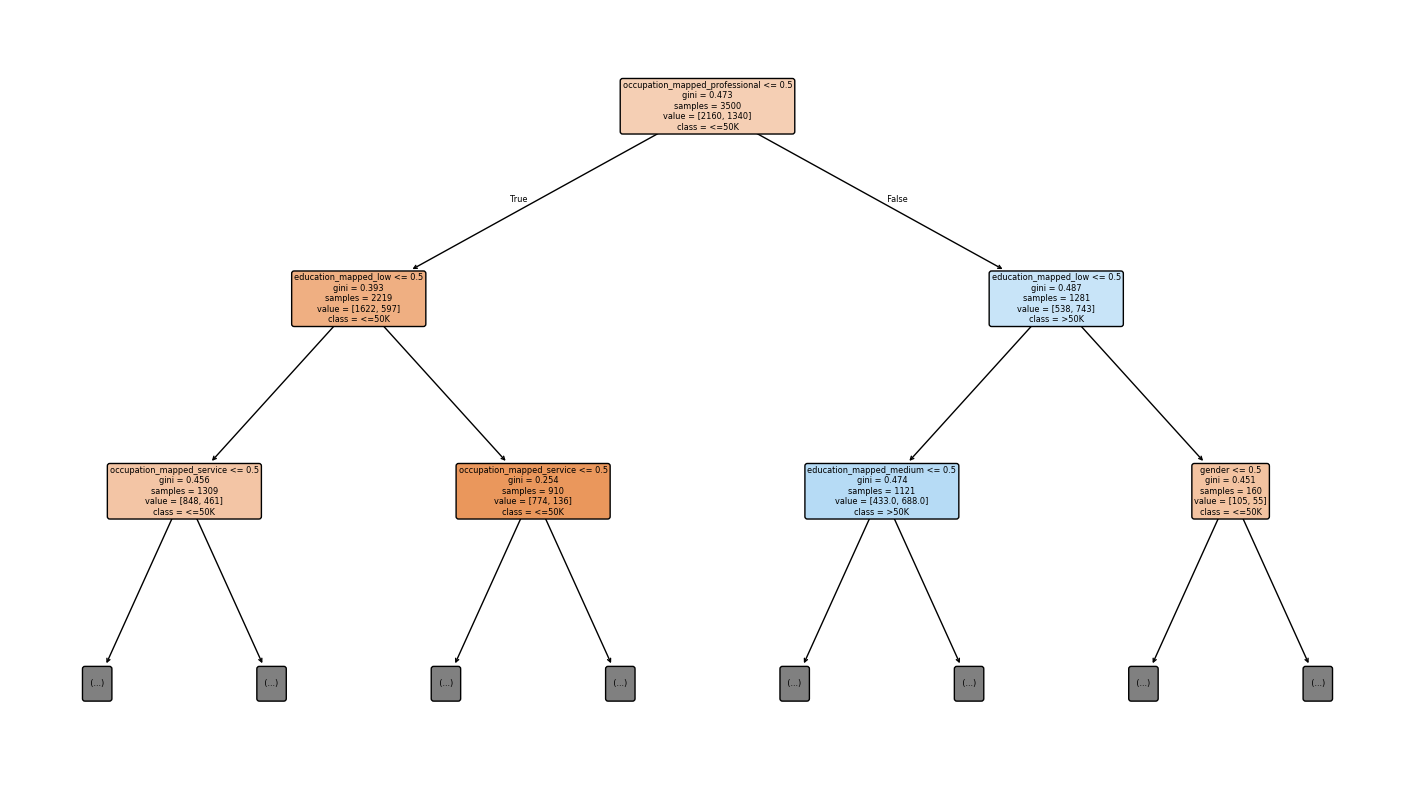

In [17]:
dt_null = evaluate_decision_tree(X_null, y_null)
plot_decision_tree(dt_null["model"], X_null.columns, max_depth=2)

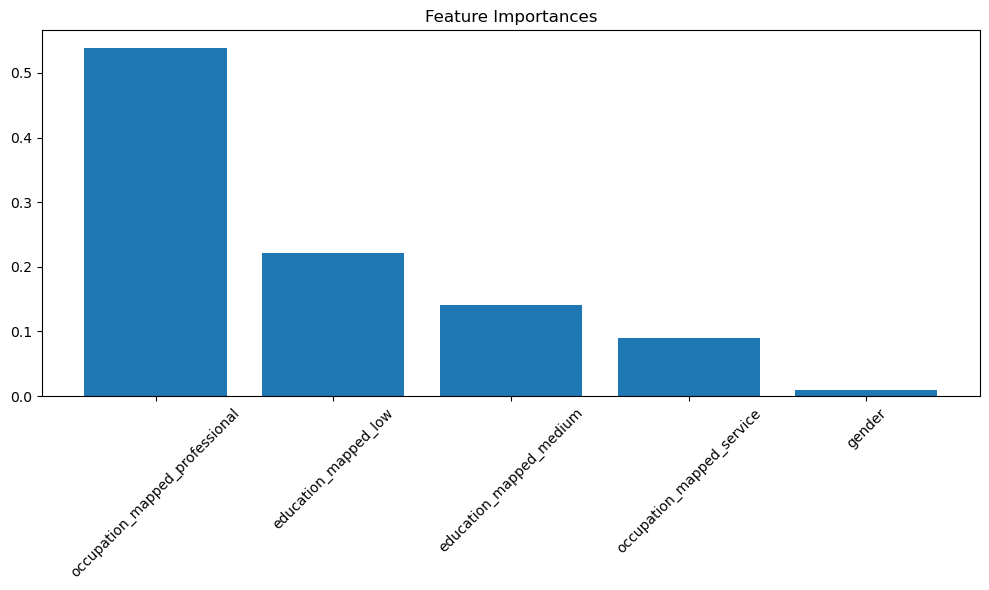

In [18]:
plot_feature_importance(dt_null["model"], X_null.columns)

### Decision Tree: Simulation H1 (with gender bias)

In [19]:
X_biased, y_biased = preprocess_dataframe(df_biased)

dt_bias = evaluate_decision_tree(X_biased, y_biased)
print("Decision Tree Accuracy (H1 - with bias):", dt_bias["accuracy"])

Decision Tree Accuracy (H1 - with bias): 0.7106666666666667


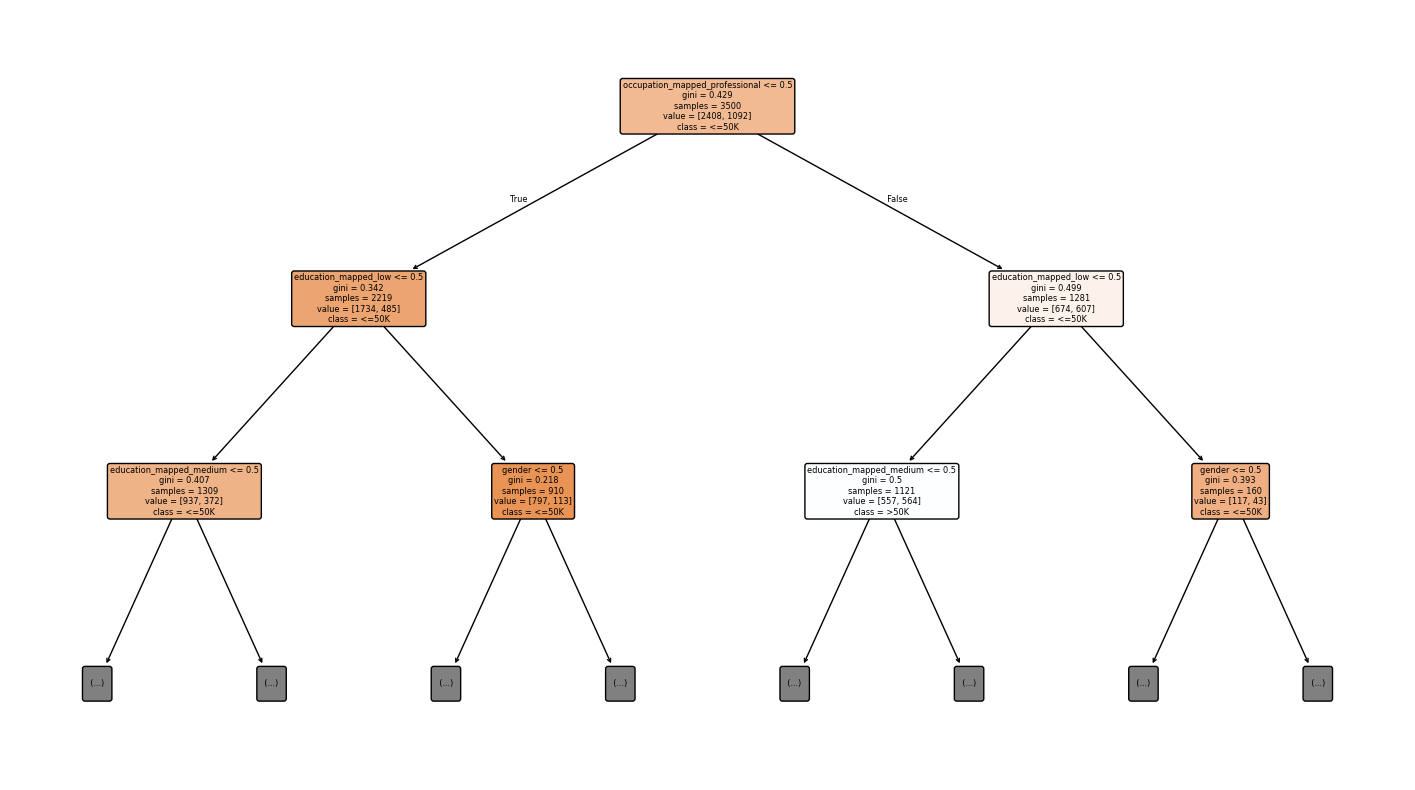

In [20]:
dt_bias = evaluate_decision_tree(X_biased, y_biased)
plot_decision_tree(dt_bias["model"], X_biased.columns, max_depth=2)

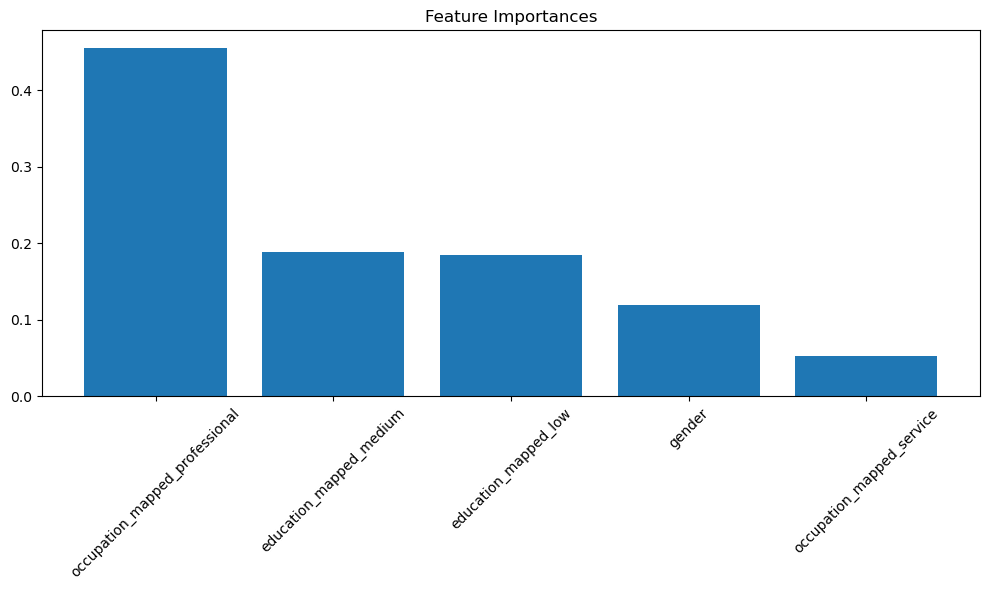

In [21]:
plot_feature_importance(dt_bias["model"], X_biased.columns)

### Decision Tree: Real Data (Adult Income Dataset)

In [22]:
dt_real = evaluate_decision_tree(X_adult, y_adult)
print("Decision Tree Accuracy (Real data):", dt_real["accuracy"])

Decision Tree Accuracy (Real data): 0.7895842387367811


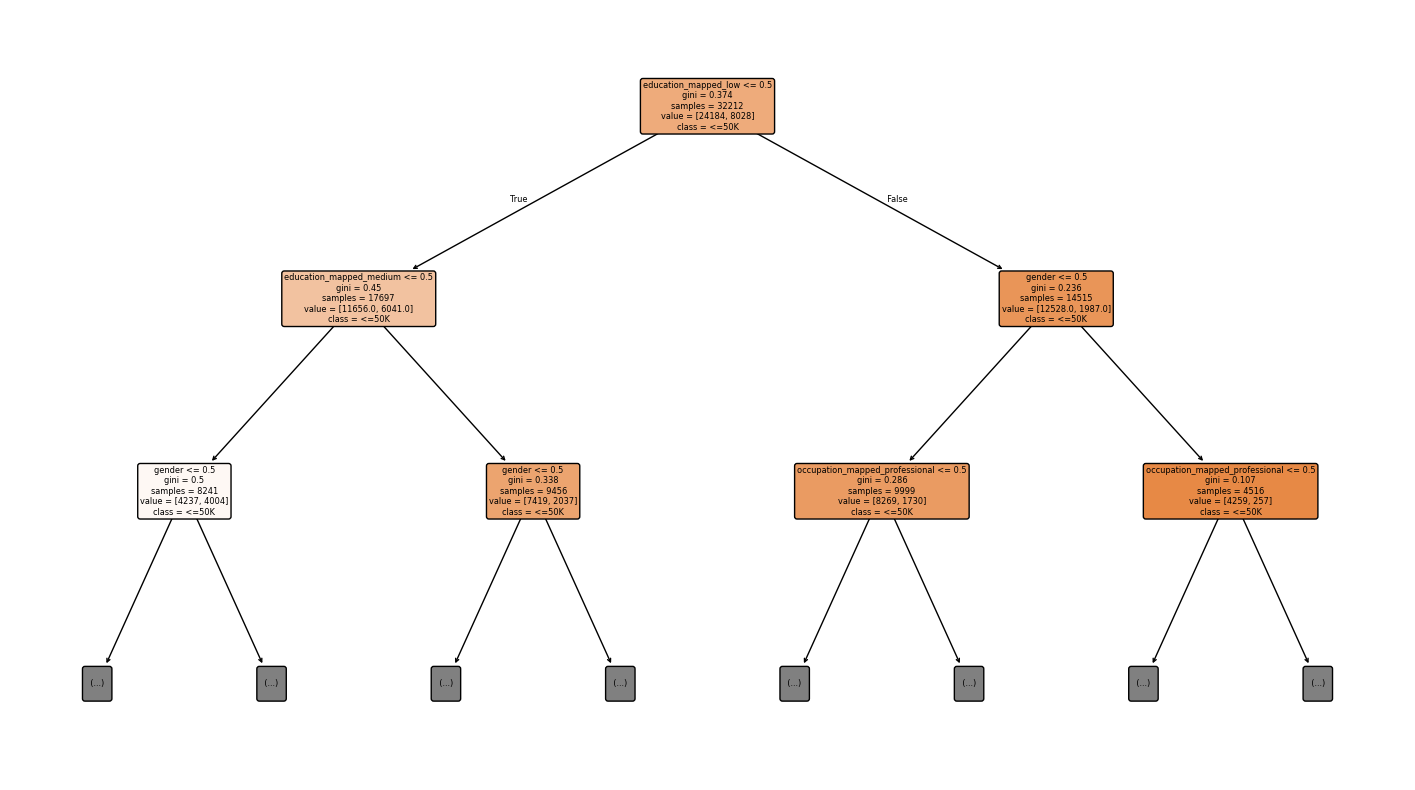

In [23]:
dt_real = evaluate_decision_tree(X_adult, y_adult)
plot_decision_tree(dt_real["model"], X_adult.columns, max_depth=2)

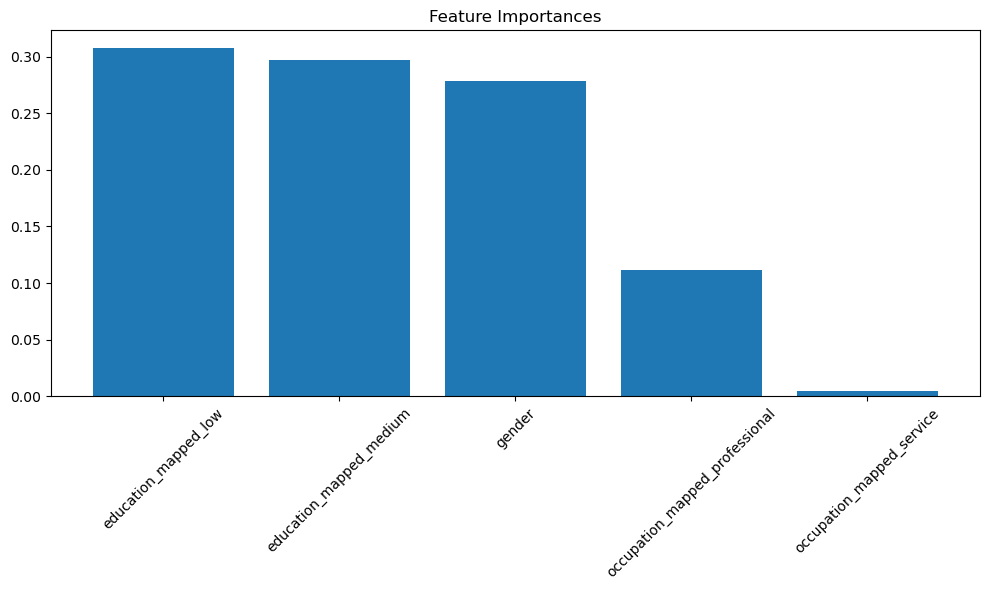

In [24]:
plot_feature_importance(dt_real["model"], X_adult.columns)

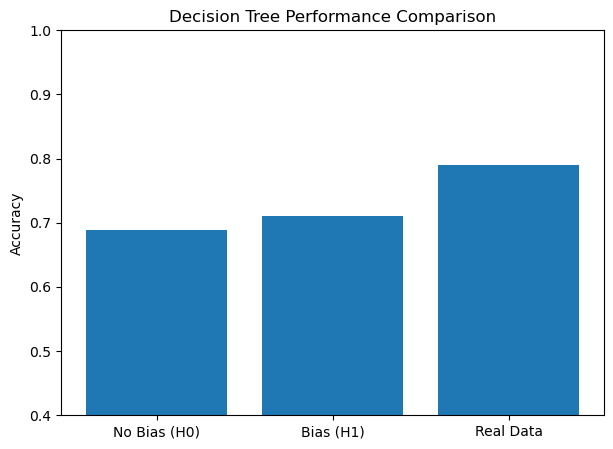

In [25]:
accuracies = {
    "No Bias (H0)": dt_null["accuracy"],
    "Bias (H1)": dt_bias["accuracy"],
    "Real Data": dt_real["accuracy"]
}

plt.figure(figsize=(7,5))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylabel("Accuracy")
plt.title("Decision Tree Performance Comparison")
plt.ylim(0.4, 1.0)
plt.show()